# 230 Project Code

Original Data: https://paperswithcode.com/dataset/liar

Dataset Description: https://www.kaggle.com/datasets/doanquanvietnamca/liar-dataset

## Imports/Data/EDA

In [1]:
! pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.8 MB/s eta 0:00:00


In [2]:
! pip install deep-translator


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.0 MB/s eta 0:00:00


In [3]:
! pip install transformers


In [4]:
import pandas as pd
import numpy as np
import itertools
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

from tqdm import tqdm
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download('wordnet')
from deep_translator import GoogleTranslator


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

import torch
from transformers import DistilBertModel, DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from transformers import EarlyStoppingCallback
from transformers import TrainingArguments, Trainer


# for plotting
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer




[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
column_names = [
    "ID",
    "label",
    "statement",
    "subject(s)",
    "speaker",
    "speaker's job title",
    "state info",
    "party affiliation",
    "barely true counts",
    "false counts",
    "half true counts",
    "mostly true counts",
    "pants on fire counts",
    "context"
]

train_df = pd.read_csv('train.tsv', sep='\t', header = None, names=column_names)
val_df = pd.read_csv('valid.tsv', sep='\t', header = None, names=column_names)
test_df = pd.read_csv('test.tsv', sep='\t', header = None, names=column_names)

train_df.head()


,ID,label,statement,subject(s),speaker,speaker's job title,state info,party affiliation,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [12]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

10240
1284
1267


In [13]:
# look at some examples of the code
print(train_df['statement'].iloc[0])
print(train_df[train_df['statement'].str.contains('trump')]['statement'].iloc[0])


Says the Annies List political group supports third-trimester abortions on demand.
Assault weapons and handguns are allowed in the state Capitol while bullhorns, trumpets, helium balloons and flags on poles are banned.


<ipython-input-10-44af6a5a306c>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, count + 0.5, f'{percentages[i]:.1f}%', ha='center',  fontsize=12)


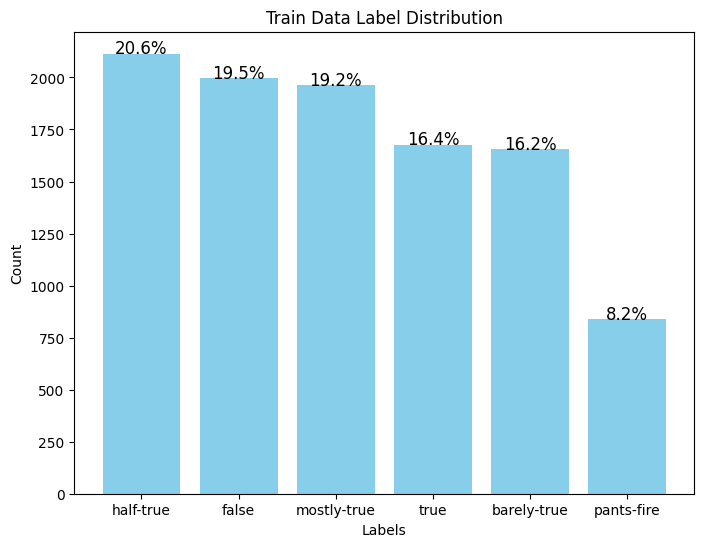

<ipython-input-10-44af6a5a306c>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, count + 0.5, f'{percentages[i]:.1f}%', ha='center',  fontsize=12)


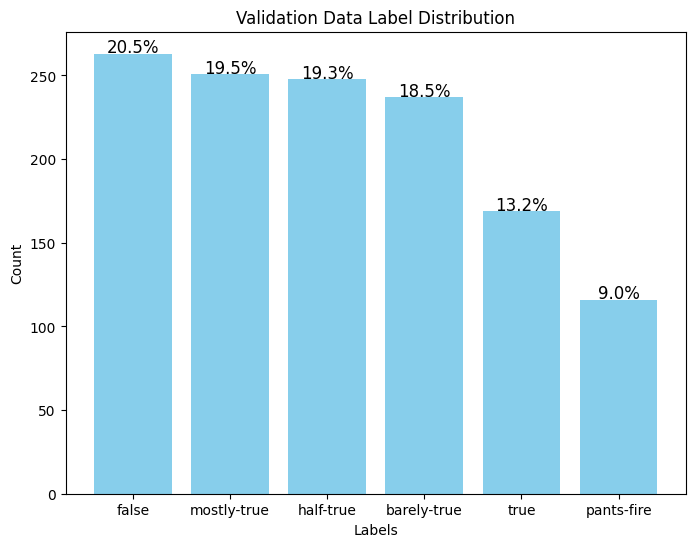

<ipython-input-10-44af6a5a306c>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, count + 0.5, f'{percentages[i]:.1f}%', ha='center',  fontsize=12)


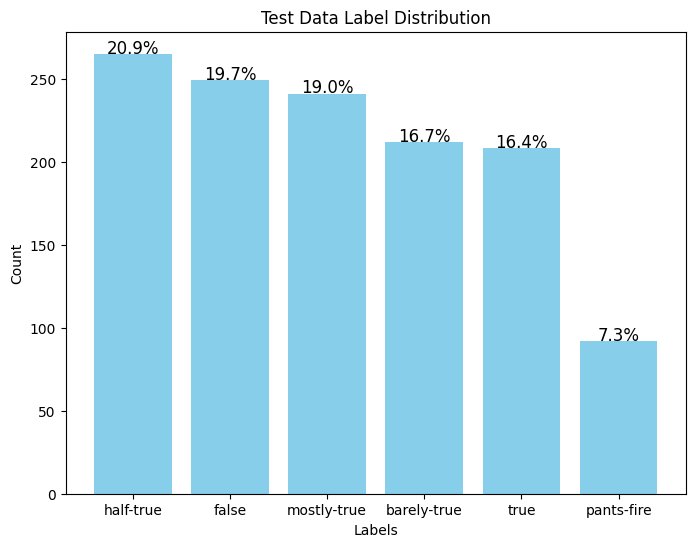

In [10]:
# CHAT GPT Assisted with the creation of this plotting function

def plot_label_distribution(df, title, color, label_column):
    counts = df[label_column].value_counts()
    percentages = df[label_column].value_counts(normalize=True) * 100

    plt.figure(figsize=(8, 6))
    plt.bar(counts.index, counts.values, color=color)
    plt.title(f'{title} Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Count')

    for i, count in enumerate(counts):
        plt.text(i, count + 0.5, f'{percentages[i]:.1f}%', ha='center',  fontsize=12)

    plt.show()

plot_label_distribution(train_df, 'Train Data', 'skyblue', 'label')
plot_label_distribution(val_df, 'Validation Data', 'skyblue', 'label')
plot_label_distribution(test_df, 'Test Data', 'skyblue', 'label')


We see that other than the "pants-fire" label, the labels are pretty evenly distributed. We will attempt to consolidate to make the classification task simpler. Our mapping will be as follows:

- True/Mostly True: true, mostly-true

- Partially True: half-true, barely-true

- False: false, pants-fire



In [11]:
label_mapping = {
    'true': 'True/Mostly True',
    'mostly-true': 'True/Mostly True',
    'half-true': 'Partially True',
    'barely-true': 'Partially True',
    'false': 'False',
    'pants-fire': 'False'
}

train_df['grouped_label'] = train_df['label'].map(label_mapping)
val_df['grouped_label'] = val_df['label'].map(label_mapping)
test_df['grouped_label'] = test_df['label'].map(label_mapping)


<ipython-input-10-44af6a5a306c>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, count + 0.5, f'{percentages[i]:.1f}%', ha='center',  fontsize=12)


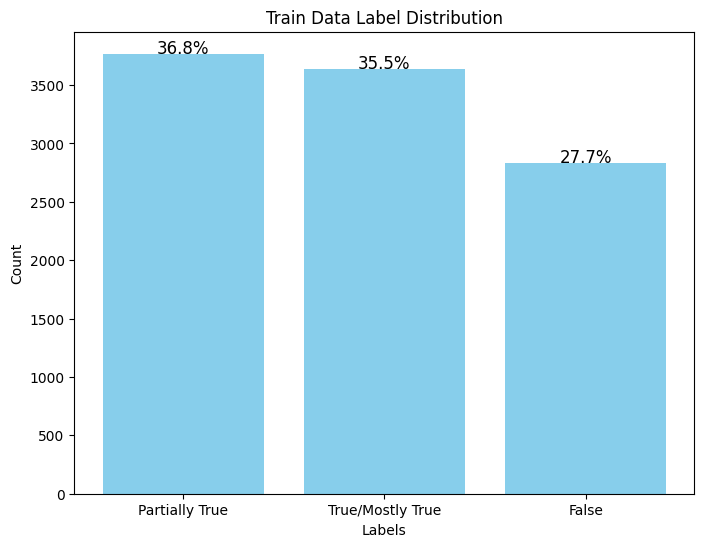

<ipython-input-10-44af6a5a306c>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, count + 0.5, f'{percentages[i]:.1f}%', ha='center',  fontsize=12)


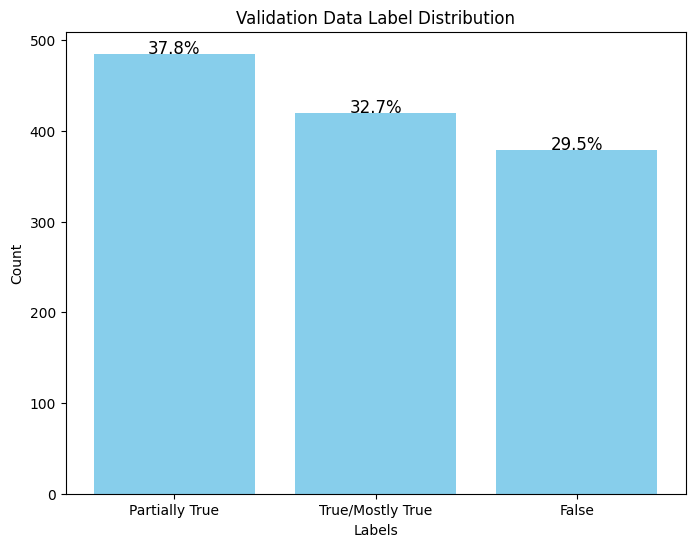

<ipython-input-10-44af6a5a306c>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, count + 0.5, f'{percentages[i]:.1f}%', ha='center',  fontsize=12)


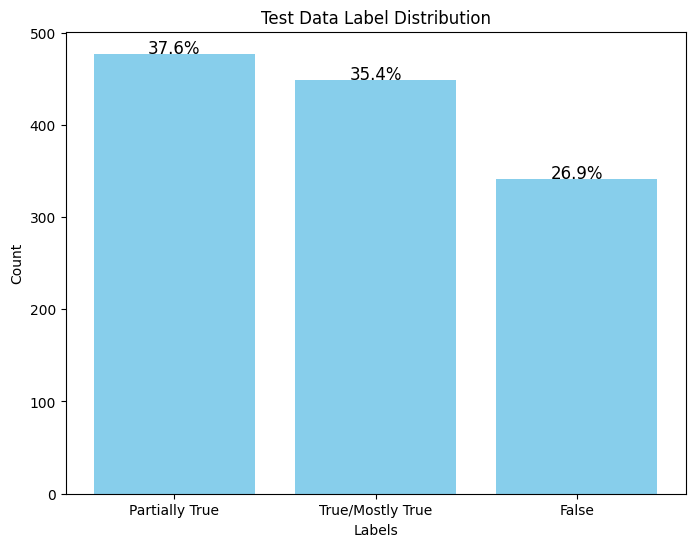

In [12]:
plot_label_distribution(train_df, 'Train Data', 'skyblue', 'grouped_label')
plot_label_distribution(val_df, 'Validation Data', 'skyblue', 'grouped_label')
plot_label_distribution(test_df, 'Test Data', 'skyblue', 'grouped_label')


## Create Augmented Version of the Data

Augmentations Include:
- 1-word random insertion
- Randomly deleting words with 20% probability
- Replacing a radom word with a synonym (using wordnet)
- backtranslation (to spanish and back) using GoogleTranslator

In [ ]:
# CHATGPT ASSISTED WITH THE CREATION OF THESE AUGMENTATION FUNCTIONS
def random_word_insertion(sentence, n=1):
    words = word_tokenize(sentence)
    for _ in range(n):
        new_word = random.choice(words)
        insert_position = random.randint(0, len(words))
        words.insert(insert_position, new_word)
    return ' '.join(words)

def random_word_deletion(sentence, p=0.2):
    words = word_tokenize(sentence)
    if len(words) == 1:
        return sentence
    retained_words = [word for word in words if random.uniform(0, 1) > p]
    return ' '.join(retained_words) if retained_words else words[0]

def synonym_replacement(sentence, n=1):
    words = word_tokenize(sentence)
    new_sentence = words[:]
    for _ in range(n):
        word_to_replace = random.choice(words)
        synonyms = wordnet.synsets(word_to_replace)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_sentence = [synonym if word == word_to_replace else word for word in new_sentence]
    return ' '.join(new_sentence)

def back_translation(sentence):
    translated = GoogleTranslator(source='en', target='es').translate(sentence)
    back_translated = GoogleTranslator(source='es', target='en').translate(translated)
    return back_translated

# test back translation
sentence = "Says the Annies List political group supports third-trimester abortions on demand."
print(back_translation(sentence))

She says the political group Annies List supports third-trimester abortions on demand.


In [ ]:
# apply augmentations to training data
# note: this cell will take a while to run

sentences = train_df['statement']
augmentation_types =  ['inserted', 'deleted', 'synonym_replaced', 'back_translated']

augmented_data = []
for row in train_df.iterrows():

    sentence = row[1]['statement']
    #print(sentence)

    # apply all the transformations
    inserted = random_word_insertion(sentence, n=1)
    deleted = random_word_deletion(sentence, p=0.2)
    synonym_replaced = synonym_replacement(sentence, n=1)
    back_translated = back_translation(sentence)

    for augmented_sentence, column_name in zip([inserted, deleted, synonym_replaced, back_translated], augmentation_types):

        # we want to replicate all other columns except for the statement
        # add column tracking augmentation type
        augmented_row = row[1].copy()
        augmented_row['statement'] = augmented_sentence
        augmented_row['augmentation_type'] = column_name
        augmented_data.append(augmented_row)
        #break
    #break


train_df_augmented = pd.DataFrame(augmented_data)

# write to csv so we do not have to re-do this step after it is done
train_df_augmented.to_csv('augmented_data.csv', index=False)


In [13]:
# combine this with the "original" statements in train_df
train_df_augmented = pd.read_csv('augmented_data.csv')
train_df['augmentation_type'] = 'original'
train_df_combined = pd.concat([train_df, train_df_augmented], ignore_index=True)

# fix boolean issue-- one 'False' is a boolean
train_df_combined['grouped_label'] = train_df_combined['grouped_label'].replace({False: 'False'})


## Baseline: Logistic Regression with TF-IDF


In [ ]:
# define X, Y for train/val/test
X_train = train_df['statement']
y_train = train_df['grouped_label']

X_val = val_df['statement']
y_val = val_df['grouped_label']

X_test = test_df['statement']
y_test = test_df['grouped_label']


In [ ]:
# use TF-IDF to vectorize the training texts
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

logreg_model = LogisticRegression()
logreg_model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [ ]:
# evaluate on validation data
y_val_pred = logreg_model.predict(X_val_tfidf)
print(classification_report(y_val, y_val_pred))

                  precision    recall  f1-score   support

           False       0.43      0.29      0.35       379
  Partially True       0.41      0.46      0.43       485
True/Mostly True       0.43      0.50      0.46       420

        accuracy                           0.42      1284
       macro avg       0.42      0.42      0.42      1284
    weighted avg       0.42      0.42      0.42      1284



In [ ]:
# evaluate on test data
y_test_pred = logreg_model.predict(X_test_tfidf)
print(classification_report(y_test, y_test_pred))

# look at confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=['False', 'Partially True', 'True/Mostly True'])
print(cm)

                  precision    recall  f1-score   support

           False       0.40      0.30      0.34       341
  Partially True       0.43      0.45      0.44       477
True/Mostly True       0.44      0.50      0.47       449

        accuracy                           0.43      1267
       macro avg       0.42      0.42      0.42      1267
    weighted avg       0.42      0.43      0.42      1267


Confusion Matrix:
[[103 125 113]
 [ 88 213 176]
 [ 68 157 224]]


We see roughly comprable performance across classes, with slightly better performance on the "True/Mostly True" category. Accuracy is pretty disappointing, but not inconsistent with what the original LIAR paper authors found in their modeling.

## LSTM

We use the following link as a resource in assisting with the LSTM creation: https://nzlul.medium.com/the-classification-of-text-messages-using-lstm-bi-lstm-and-gru-f79b207f90ad

In [ ]:
# first, get some statistics of the dataset
for name, dataset in {'X_train': X_train, 'X_val': X_val, 'X_test': X_test}.items():
    lengths = [len(i.split()) for i in dataset]
    avg_length = sum(lengths) / len(dataset)
    max_length = max(lengths)
    percentile_length = np.percentile(lengths, 95)

    print(f"Average length of statement in {name}: {avg_length:.2f}")
    print(f"Maximum length of statement in {name}: {max_length}")
    print(f"95th Percentile Length of statements in {name}: {percentile_length:.2f}")
    print("\n")

# given this, we can use 40 padding (account for 95th percentile )

Average length of statement in X_train: 18.01
Maximum length of statement in X_train: 467
95th Percentile Length of statements in X_train: 33.00


Average length of statement in X_val: 17.93
Maximum length of statement in X_val: 57
95th Percentile Length of statements in X_val: 32.00


Average length of statement in X_test: 18.40
Maximum length of statement in X_test: 431
95th Percentile Length of statements in X_test: 32.00




In [ ]:
# do label encoding for the "label" outcome to have numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# tokenize texts
# selected 5000 as recommended by resources online
# fit tokenizer to training data
tokenizer = Tokenizer(num_words=5000, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train)

# convert the texts to sequences for LSTM
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
# set pad length to 40 because of the averages/percentiles observed previously
# pre padding recommended for LSTMs
X_train_pad = pad_sequences(X_train_seq, padding='pre', maxlen=40)
X_val_pad = pad_sequences(X_val_seq, padding='pre', maxlen=40)
X_test_pad = pad_sequences(X_test_seq, padding='pre', maxlen=40)

print(X_train_pad.shape)
print(X_val_pad.shape)
print(X_test_pad.shape)


(10240, 40)
(1284, 40)
(1267, 40)


### Hyperparameter Tuning

In [ ]:
# CHATGPT and https://nzlul.medium.com/the-classification-of-text-messages-using-lstm-bi-lstm-and-gru-f79b207f90ad
# assisted in the HP tuning and the structure of the LSTM

def build_model(hp):
    model = Sequential()

    # start with embedding layer
    # we will fix output dimension to 100 as this is standard for embedding layers
    model.add(Embedding(
        input_dim=5000,
        output_dim=100,
        input_length=40
    ))

    # add LSTM layer
    # HPs: # nunits, dropout probabilities
    model.add(LSTM(
        units=hp.Choice('lstm_units', [64, 128, 256]),
        dropout=hp.Choice('dropout', [0.1, 0.2, 0.5]),
        recurrent_dropout=hp.Choice('recurrent_dropout', [0.1, 0.2, 0.5])
    ))

    # add dense layer
    # HPs: # unints
    model.add(Dense(
        units=hp.Choice('dense_units', [32, 64, 128]),
        activation='relu'
    ))

    # add softmax activation for 3-class classification
    model.add(Dense(3, activation='softmax'))

    # log sample learning rate from 1e-4 to 1e-2
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# track performance on validation set
# stick with accuracy as metric because of rough class balance
# limit to 15 trials (takes very long otherwise)
# 5 epochs
# batch size 32

# random search preferable to grid search
tuner = kt.RandomSearch(
    build_model,
    objective ='val_accuracy',
    max_trials = 15,
    directory='LSTM',
    project_name='HP_tuning',
    seed = 230
)

tuner.search(X_train_pad, y_train_encoded,
             validation_data=(X_val_pad, y_val_encoded), epochs=5,
             batch_size=32)


# best model resulting from HP tuning
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hps)

print("Best Hyperparameters:")
print(best_hps.values)

Reloading Tuner from LSTM/HP_tuning/tuner0.json
Best Hyperparameters:
{'lstm_units': 64, 'dropout': 0.2, 'recurrent_dropout': 0.1, 'dense_units': 64, 'learning_rate': 0.00011998472287810798}


In [ ]:
# train the model with the best parameters
# include early stopping for training

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

history = best_model.fit(
    X_train_pad, y_train_encoded,
    validation_data=(X_val_pad, y_val_encoded),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping])

Epoch 1/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 44s 116ms/step - accuracy: 0.3744 - loss: 1.0954 - val_accuracy: 0.3723 - val_loss: 1.0891
Epoch 2/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.4051 - loss: 1.0803 - val_accuracy: 0.4439 - val_loss: 1.0641
Epoch 3/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 52s 163ms/step - accuracy: 0.4538 - loss: 1.0443 - val_accuracy: 0.4463 - val_loss: 1.0455
Epoch 4/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 57s 84ms/step - accuracy: 0.5141 - loss: 0.9897 - val_accuracy: 0.4494 - val_loss: 1.0484
Epoch 5/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 62s 149ms/step - accuracy: 0.5617 - loss: 0.9367 - val_accuracy: 0.4330 - val_loss: 1.0777
Epoch 6/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 48s 149ms/step - accuracy: 0.5985 - loss: 0.8811 - val_accuracy: 0.4213 - val_loss: 1.1124
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


In [ ]:
# test set performance
test_loss, test_accuracy = best_model.evaluate(X_test_pad, y_test_encoded, verbose=1)

# predictions on test set
y_test_pred = best_model.predict(X_test_pad)
y_test_pred = np.argmax(y_test_pred, axis=1)
print(classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test_encoded, y_test_pred)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
print(cm_df)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4203 - loss: 1.0577
Test Loss: 1.0532
Test Accuracy: 0.4396
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
                  precision    recall  f1-score   support

           False       0.39      0.37      0.38       341
  Partially True       0.44      0.38      0.41       477
True/Mostly True       0.47      0.55      0.51       449

        accuracy                           0.44      1267
       macro avg       0.43      0.44      0.43      1267
    weighted avg       0.44      0.44      0.44      1267


Confusion Matrix:
                  False  Partially True  True/Mostly True
False               126             102               113
Partially True      122             183               172
True/Mostly True     73             128               248


### Use Data Augmentation within LSTM

- Retrain the LSTM model with the augmented training data
- Use the HPs selected from tuning on the original data


In [ ]:
# now re-train with augmented data
# need to re-pad the data
# re-use the "best" hyperparameters (not ideal but saves time on HP tuning)
# same code as above, just wit train_df_combined instead

X_train_augmented = train_df_combined['statement']
y_train_augmented = train_df_combined['grouped_label']

# do label encoding for the "label" outcome to have numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# tokenize texts
# selected 5000 as recommended by resources online
# fit tokenizer to training data
tokenizer = Tokenizer(num_words=5000, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train)

# convert the texts to sequences for LSTM
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
# set pad length to 40 because of the averages/percentiles observed previously
# pre padding recommended for LSTMs
X_train_pad = pad_sequences(X_train_seq, padding='pre', maxlen=40)
X_val_pad = pad_sequences(X_val_seq, padding='pre', maxlen=40)
X_test_pad = pad_sequences(X_test_seq, padding='pre', maxlen=40)

print(X_train_pad.shape)
print(X_val_pad.shape)
print(X_test_pad.shape)

(10240, 40)
(1284, 40)
(1267, 40)


In [ ]:
# use HPs from "best" model
# ideally we will do HP tuning again, but might be time consuming
# {'lstm_units': 64, 'dropout': 0.2, 'recurrent_dropout': 0.1, 'dense_units': 64, 'learning_rate': 0.00011998472287810798}
# we can still use early stopping
# still 5 epochs, batch size 32

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100, input_length=40))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.00011998472287810798),
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train_pad, y_train_encoded,
                    epochs=5,
                    batch_size=32,
                    validation_data=(X_val_pad, y_val_encoded),
                     callbacks=[early_stopping])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 35s 102ms/step - accuracy: 0.3713 - loss: 1.0948 - val_accuracy: 0.3964 - val_loss: 1.0844
Epoch 2/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 44s 111ms/step - accuracy: 0.4051 - loss: 1.0772 - val_accuracy: 0.4400 - val_loss: 1.0593
Epoch 3/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.4600 - loss: 1.0421 - val_accuracy: 0.4470 - val_loss: 1.0450
Epoch 4/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 39s 121ms/step - accuracy: 0.5188 - loss: 0.9817 - val_accuracy: 0.4315 - val_loss: 1.0649
Epoch 5/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.5664 - loss: 0.9248 - val_accuracy: 0.4291 - val_loss: 1.1028
Restoring model weights from the end of the best epoch: 3.


In [ ]:
# test set performance
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test_encoded, verbose=1)

# predictions on test set
y_test_pred = model.predict(X_test_pad)
y_test_pred = np.argmax(y_test_pred, axis=1)
print(classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test_encoded, y_test_pred)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
print(cm_df)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.4049 - loss: 1.0647
Test Loss: 1.0602
Test Accuracy: 0.4254
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
                  precision    recall  f1-score   support

           False       0.38      0.43      0.40       341
  Partially True       0.40      0.39      0.40       477
True/Mostly True       0.50      0.45      0.48       449

        accuracy                           0.43      1267
       macro avg       0.43      0.43      0.43      1267
    weighted avg       0.43      0.43      0.43      1267


Confusion Matrix:
                  False  Partially True  True/Mostly True
False               147             129                65
Partially True      151             188               138
True/Mostly True     93             152               204


## Contrastive Learning

- We can create an embedding model by feeding in "positive" and "negative" pairs of statements, and train the model to distinguish pairs of statements.
- Once we have embedding model, we can use logistic regression trained on embeddings to predict truth label
- We will use DistilBert for embedding
- We adopt a siamese architecture
- Resource: https://www.google.com/url?q=https%3A%2F%2Fmedium.com%2F%40heyamit10%2Fcontrastive-learning-of-sentence-embeddings-from-scratch-33146cd756b9 assisted with siamese architecture


In [ ]:
# we will use distilbert as it is smaller/quicker
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


In [ ]:
# siamese BERT model:
# RESOURCE: https://www.google.com/url?q=https%3A%2F%2Fmedium.com%2F%40heyamit10%2Fcontrastive-learning-of-sentence-embeddings-from-scratch-33146cd756b9
class SiameseDistilBERT(nn.Module):
    def __init__(self, model):
        super(SiameseDistilBERT, self).__init__()
        self.distilbert = model

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        # CLS token is the embedding that we want
        cls_output = outputs.last_hidden_state[:, 0, :]
        return cls_output

In [ ]:
# custom dataset class for sentence pairs
# can pass this into the SiameseDistilBERT
# CHATGPT assisted with the creation of this class

class ContrastivePairs(Dataset):
    def __init__(self, sentence1_list, sentence2_list, labels, tokenizer, max_length=128):
        self.sentence1_list = sentence1_list
        self.sentence2_list = sentence2_list
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentence1_list)

    def __getitem__(self, idx):
        sentence1 = self.sentence1_list[idx]
        sentence2 = self.sentence2_list[idx]
        label = self.labels[idx]

        # tokenize the input sentences
        encoding1 = self.tokenizer(sentence1, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        encoding2 = self.tokenizer(sentence2, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)

        # get dimensions correct
        input_ids1 = encoding1['input_ids'].squeeze(0)
        attention_mask1 = encoding1['attention_mask'].squeeze(0)
        input_ids2 = encoding2['input_ids'].squeeze(0)
        attention_mask2 = encoding2['attention_mask'].squeeze(0)

        return input_ids1, attention_mask1, input_ids2, attention_mask2, torch.tensor(label, dtype=torch.float32)


In [ ]:
# CHATGPT assisted with the creation of these functions

# this function is used to get the embeddings of a new sentence (val/test set)
def get_sentence_embedding(model, tokenizer, sentence, device, max_length=128):
    model.eval()
    with torch.no_grad():
        # tokenize and encode the sentence to be embedded
        encoding = tokenizer(sentence, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        # get embeddings from the model (clf token)
        output = model(input_ids, attention_mask=attention_mask)
        return output.cpu().numpy()

# loop through sentences and get embeddings for all-- stack together into one dataset
def get_sentence_embeddings(model, tokenizer, sentences, device, max_length=128):
    embeddings = []
    for sentence in sentences:
        embedding = get_sentence_embedding(model, tokenizer, sentence, device, max_length)
        embeddings.append(embedding)
    return np.vstack(embeddings)

### Approach 1: Self-Supervised Labels
- We can use augmented data to create positive and negative pairs
- Positive: (original, augmented version)
- Negative: (original, unrelated sentence)



In [ ]:
positive_pairs = []

# id uniquely identifies the statement (and all augmented versions)
for statement_id, group in train_df_combined.groupby('ID'):
    original_row = group[group['augmentation_type'] == 'original']
    original_statement = original_row['statement'].values[0]

    # iterate through original and all 4 augmented versions
    for row in group.iterrows():
        # add "positive pair" (original, augmented) with label 1
        if row[1]['augmentation_type'] != 'original':
                positive_pairs.append({
                    'sentence1': original_statement,
                    'sentence2': row[1]['statement'],
                    'label': 1
                })
                #print("appended")

negative_pairs = []
for statement_id, group in train_df_combined.groupby('ID'):
    original_row = group[group['augmentation_type'] == 'original']
    original_statement = original_row['statement'].values[0]

    # randomly sample one instance from the rest of the df
    negative_sample = train_df_combined[train_df_combined['ID'] != statement_id].sample(1)
    # add "negative pair" (original, random) with label 0
    negative_pairs.append({
                'sentence1': original_statement,
                'sentence2': negative_sample['statement'].values[0],
                'label': 0  # Label 0 for negative pairs
            })

contrastive_pairs = positive_pairs + negative_pairs
contrastive_pairs_df = pd.DataFrame(contrastive_pairs)

In [ ]:
# balance the dataframe between positive and negative samples
# currently way too positive heavy
# downsample the positive class by having one positive pair per original statement

len(contrastive_pairs_df)
print(sum(contrastive_pairs_df['label'])/len(contrastive_pairs_df))

pos_df = contrastive_pairs_df[contrastive_pairs_df['label'] == 1]
neg_df = contrastive_pairs_df[contrastive_pairs_df['label'] == 0]

pos_df_downsampled = (
    pos_df.groupby('sentence1').apply(lambda group: group.sample(n=1, random_state=230))
      .reset_index(drop=True)
)
contrastive_balanced_df = pd.concat([pos_df_downsampled, neg_df]).sample(frac=1, random_state=230)
print(sum(contrastive_balanced_df['label'])/len(contrastive_balanced_df))



0.7904344800769498
0.48490945674044267


<ipython-input-188-8110dbc69721>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sample(n=1, random_state=230))


In [ ]:
contrastive_balanced_df.head()

,sentence1,sentence2,label
42610,We now have our kids go to school about a mont...,Trump Says Paul Ryan is still endorsing Trump .,0
45852,The new 21st State Senate district was created...,same Says John Boehner admits we are not going...,0
47349,According to a recent Congressional Budget Off...,"Says his , former Gov . Linwood Holton , integ...",0
5781,"Says Wisconsin state Sen. Randy Hopper, R-Fond...","Says Sen. Randy Hopper , R-Fond Lac has alread...",1
44154,Says the states pension and health benefits re...,A hundred percent of all the jobs lost during ...,0


In [ ]:
# convert the sentence pairs to an instance of this class
sentence1_list = list(contrastive_balanced_df['sentence1'])
sentence2_list = list(contrastive_balanced_df['sentence2'])
labels = list(contrastive_balanced_df['label'])

dataset = ContrastivePairs(sentence1_list, sentence2_list, labels, tokenizer)
dataloader = DataLoader(dataset, batch_size= 32, shuffle=True)


In [ ]:
# CHATGPT assisted with the siamese network training


# train the Siamese Network
model = SiameseDistilBERT(distilbert_model)

# use BCE loss as we are predicting binary labels
loss_fn = nn.BCELoss()

# for now, we will choose lr=1e-5
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# use 3 epochs for now
num_epochs = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids1, attention_mask1, input_ids2, attention_mask2, labels = batch
        input_ids1, attention_mask1 = input_ids1.to(device), attention_mask1.to(device)
        input_ids2, attention_mask2 = input_ids2.to(device), attention_mask2.to(device)
        labels = labels.to(device)

        # forward pass
        embedding1 = model(input_ids1, attention_mask1)
        embedding2 = model(input_ids2, attention_mask2)

        # compute cosine similarity and prepare targets for binary cross-entropy
        cosine_similarity = torch.nn.functional.cosine_similarity(embedding1, embedding2)
        predictions = torch.sigmoid(cosine_similarity)

        # calculate BCE loss
        loss = loss_fn(predictions, labels)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print average loss for the epoch
    print(f'Epoch {epoch + 1}, Loss: {total_loss / len(dataloader):.4f}')


Epoch 1/3: 100%|██████████| 622/622 [06:31<00:00,  1.59it/s]


Epoch 1, Loss: 0.5510


Epoch 2/3: 100%|██████████| 622/622 [06:30<00:00,  1.59it/s]


Epoch 2, Loss: 0.5273


Epoch 3/3: 100%|██████████| 622/622 [06:30<00:00,  1.59it/s]

Epoch 3, Loss: 0.5170


In [ ]:
# use the trained model to get embeddings for the statements in the original train, validation, and test sets
# we will use these embeddings in a logistic regression model

#train
train_sentences = list(train_df['statement'])
X_train = get_sentence_embeddings(model, tokenizer, train_sentences, device)
y_train = list(train_df['grouped_label'])


#validation
val_sentences = list(val_df['statement'])
X_val = get_sentence_embeddings(model, tokenizer, val_sentences, device)
y_val = list(val_df['grouped_label'])

#test
test_sentences = list(test_df['statement'])  # List of sentences from the test set
X_test = get_sentence_embeddings(model, tokenizer, test_sentences, device)
y_test = list(test_df['grouped_label'])


In [ ]:
# train the logistic regression model
logreg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
logreg.fit(X_train, y_train)

# predict and evaluate on the validation set
y_val_pred = logreg.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(classification_report(y_val, y_val_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
conf_matrix = confusion_matrix(y_val, y_val_pred)
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy: 0.4502
Validation Classification Report:
              precision    recall  f1-score   support

     Class 1       0.46      0.33      0.39       379
     Class 2       0.43      0.47      0.45       485
     Class 3       0.46      0.54      0.50       420

    accuracy                           0.45      1284
   macro avg       0.45      0.45      0.44      1284
weighted avg       0.45      0.45      0.45      1284

[[126 156  97]
 [ 92 226 167]
 [ 53 141 226]]


In [ ]:
# predict and evaluate on the test set
y_test_pred = logreg.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(conf_matrix)

Test Accuracy: 0.4428
Test Classification Report:
              precision    recall  f1-score   support

     Class 1       0.39      0.32      0.35       341
     Class 2       0.44      0.47      0.45       477
     Class 3       0.47      0.51      0.49       449

    accuracy                           0.44      1267
   macro avg       0.44      0.43      0.43      1267
weighted avg       0.44      0.44      0.44      1267

[[108 135  98]
 [ 96 223 158]
 [ 71 148 230]]


### Approach 2: "Supervised" Labels

* We will use the truthfulness labels to create positive and negative pairs
* Positive: Two statements that have the same truthfulness rating (randomly chosen)
* Negative: Two statements that do not have the same truthfulness rating (randomly chosen)
* After creating the contrastive learning dataset in this way, we will execute the same steps as in the first approach




In [ ]:
# create a new contrastive_df

positive_pairs = []
# group by the truth label so we can create random pairs
grouped = train_df.groupby('grouped_label')
for label, group in grouped:
    sentences = group['statement'].tolist()
    # find every positive pair (anything within the group is eligible)
    positive_pairs.extend([(s1, s2, 1) for s1, s2 in itertools.combinations(sentences, 2)])

# sample down positive pairs to one per sentence so that there aren't too many
positive_df = pd.DataFrame(positive_pairs, columns=['sentence1', 'sentence2', 'label'])
positive_df = positive_df.groupby('sentence1').sample(n=1, random_state=230)

negative_pairs = []
all_sentences = list(train_df['statement'])
labels = list(train_df['grouped_label'])
for i, (sent, label) in enumerate(zip(all_sentences, labels)):
    negative_samples = train_df[train_df['grouped_label'] != label]['statement'] \
        .sample(n=1, random_state=i, replace=True).tolist()
    negative_pairs.extend([(sent, neg_sent, 0) for neg_sent in negative_samples])

negative_df = pd.DataFrame(negative_pairs, columns=['sentence1', 'sentence2', 'label'])
contrastive_df = pd.concat([positive_df, negative_df], ignore_index=True)



In [ ]:
# check if it is balanced!
# rename to contrastive_balanced_df if it is not balanced

print(sum(contrastive_df['label'])/len(contrastive_df))
contrastive_balanced_df = contrastive_df

In [ ]:
# convert the sentence pairs to an instance of this class
sentence1_list = list(contrastive_balanced_df['sentence1'])
sentence2_list = list(contrastive_balanced_df['sentence2'])
labels = list(contrastive_balanced_df['label'])

dataset = ContrastivePairs(sentence1_list, sentence2_list, labels, tokenizer)
dataloader = DataLoader(dataset, batch_size= 32, shuffle=True)


In [ ]:
# CHATGPT assisted with the siamese network training


# train the Siamese Network
model = SiameseDistilBERT(distilbert_model)

# use BCE loss as we are predicting binary labels
loss_fn = nn.BCELoss()

# for now, we will choose lr=1e-5
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# use 3 epochs for now
num_epochs = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_ids1, attention_mask1, input_ids2, attention_mask2, labels = batch
        input_ids1, attention_mask1 = input_ids1.to(device), attention_mask1.to(device)
        input_ids2, attention_mask2 = input_ids2.to(device), attention_mask2.to(device)
        labels = labels.to(device)

        # forward pass
        embedding1 = model(input_ids1, attention_mask1)
        embedding2 = model(input_ids2, attention_mask2)

        # compute cosine similarity and prepare targets for binary cross-entropy
        cosine_similarity = torch.nn.functional.cosine_similarity(embedding1, embedding2)
        predictions = torch.sigmoid(cosine_similarity)

        # calculate BCE loss
        loss = loss_fn(predictions, labels)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print average loss for the epoch
    print(f'Epoch {epoch + 1}, Loss: {total_loss / len(dataloader):.4f}')


Epoch 1/3: 100%|██████████| 10230/10230 [13:46<00:00, 12.37it/s]


Epoch 1/3, Loss: 0.6980


Epoch 2/3: 100%|██████████| 10230/10230 [13:48<00:00, 12.35it/s]


Epoch 2/3, Loss: 0.6763


Epoch 3/3: 100%|██████████| 10230/10230 [12:59<00:00, 13.12it/s]

Epoch 3/3, Loss: 0.6421
Training completed.


In [ ]:
# use the trained model to get embeddings for the statements in the original train, validation, and test sets
# we will use these embeddings in a logistic regression model

#train
train_sentences = list(train_df['statement'])
X_train = get_sentence_embeddings(model, tokenizer, train_sentences, device)
y_train = list(train_df['grouped_label'])


#validation
val_sentences = list(val_df['statement'])
X_val = get_sentence_embeddings(model, tokenizer, val_sentences, device)
y_val = list(val_df['grouped_label'])

#test
test_sentences = list(test_df['statement'])  # List of sentences from the test set
X_test = get_sentence_embeddings(model, tokenizer, test_sentences, device)
y_test = list(test_df['grouped_label'])


In [ ]:
# train the logistic regression model
logreg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
logreg.fit(X_train, y_train)

# predict and evaluate on the validation set
y_val_pred = logreg.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print('Validation Classification Report:')
print(classification_report(y_val, y_val_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
conf_matrix = confusion_matrix(y_val, y_val_pred)
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy: 0.4260
Validation Classification Report:
              precision    recall  f1-score   support

     Class 1       0.40      0.35      0.37       379
     Class 2       0.43      0.45      0.44       485
     Class 3       0.44      0.47      0.46       420

    accuracy                           0.43      1284
   macro avg       0.42      0.42      0.42      1284
weighted avg       0.42      0.43      0.42      1284

[[132 150  97]
 [115 216 154]
 [ 83 138 199]]


In [ ]:
# predict and evaluate on the test set
y_test_pred = logreg.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')
print('Test Classification Report:')
print(classification_report(y_test, y_test_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(conf_matrix)

Test Accuracy: 0.4491
Test Classification Report:
              precision    recall  f1-score   support

     Class 1       0.39      0.37      0.38       341
     Class 2       0.43      0.47      0.45       477
     Class 3       0.51      0.49      0.50       449

    accuracy                           0.45      1267
   macro avg       0.45      0.44      0.44      1267
weighted avg       0.45      0.45      0.45      1267

[[125 142  74]
 [118 225 134]
 [ 76 154 219]]


# Pre-Trained BERT

* Will use DistilBERT for faster training

In [14]:
# this class prepares the statements for the right format to be used
# with the DistilBERT model

# Chat GPT assisted in the creation of this class

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# function passed to Trainer
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {"accuracy": accuracy_score(labels, preds)}

## Non-Augmented Data

- first we will fine-tune BERT on the original version of the data

In [19]:

X_train = train_df['statement']
y_train = train_df['grouped_label']

X_val = val_df['statement']
y_val = val_df['grouped_label']

X_test = test_df['statement']
y_test = test_df['grouped_label']


# use distilBERT
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# tokenize input data
X_train_tokenized = tokenizer(list(X_train), padding="max_length", truncation=True, max_length=128)
X_val_tokenized = tokenizer(list(X_val), padding="max_length", truncation=True, max_length=128)
X_test_tokenized = tokenizer(list(X_test), padding="max_length", truncation=True, max_length=128)


In [20]:
# convert data into class that can be used by DistilBERT

train_dataset = SentimentDataset(X_train_tokenized, y_train_encoded)
val_dataset = SentimentDataset(X_val_tokenized, y_val_encoded)
test_dataset = SentimentDataset(X_test_tokenized, y_test_encoded)

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# CHATGPT assisted with the trainingargs and trainer setup

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    load_best_model_at_end=True
)

# we want to use early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# train model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.060500,1.029495,0.474299
2,0.945200,1.040565,0.476636
3,0.741000,1.190901,0.465732
4,0.459700,1.628381,0.450935


TrainOutput(global_step=5120, training_loss=0.8020833879709244, metrics={'train_runtime': 631.5456, 'train_samples_per_second': 162.142, 'train_steps_per_second': 20.268, 'total_flos': 1356490352885760.0, 'train_loss': 0.8020833879709244, 'epoch': 4.0})

In [ ]:
# evaluate on test
test_results = trainer.evaluate(test_dataset)
print(test_results)

predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(-1)
y_true = predictions.label_ids
print(classification_report(y_true, predicted_labels, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, predicted_labels)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
print(cm_df)


{'eval_loss': 1.03618586063385, 'eval_accuracy': 0.4546172059984215, 'eval_runtime': 4.4128, 'eval_samples_per_second': 287.118, 'eval_steps_per_second': 36.031, 'epoch': 4.0}
                  precision    recall  f1-score   support

           False       0.41      0.31      0.35       341
  Partially True       0.44      0.39      0.41       477
True/Mostly True       0.48      0.63      0.55       449

        accuracy                           0.45      1267
       macro avg       0.44      0.44      0.44      1267
    weighted avg       0.45      0.45      0.45      1267


Confusion Matrix:
                  False  Partially True  True/Mostly True
False               107             117               117
Partially True      107             184               186
True/Mostly True     49             115               285


### Augmented Data
- Next, we fine-tune BERT on augmented data
- Most code looks the same

In [21]:
# do label encoding for the "label" outcome to have numerical values


X_train = train_df_combined['statement']
y_train = train_df_combined['grouped_label']

X_val = val_df['statement']
y_val = val_df['grouped_label']

X_test = test_df['statement']
y_test = test_df['grouped_label']


tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

X_train_tokenized = tokenizer(list(X_train), padding="max_length", truncation=True, max_length=128)
X_val_tokenized = tokenizer(list(X_val), padding="max_length", truncation=True, max_length=128)
X_test_tokenized = tokenizer(list(X_test), padding="max_length", truncation=True, max_length=128)


In [22]:
# same steps as before

train_dataset = SentimentDataset(X_train_tokenized, y_train_encoded)
val_dataset = SentimentDataset(X_val_tokenized, y_val_encoded)
test_dataset = SentimentDataset(X_test_tokenized, y_test_encoded)


In [23]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_))


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# CHATGPT assisted with the trainingargs and trainer setup
# same as before
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.058500,1.027985,0.459502
2,0.928700,1.045783,0.482866


Epoch,Training Loss,Validation Loss,Accuracy
1,1.058500,1.027985,0.459502
2,0.928700,1.045783,0.482866
3,0.717600,1.190913,0.458723
4,0.430000,1.649850,0.459502


TrainOutput(global_step=5120, training_loss=0.7869598411023617, metrics={'train_runtime': 592.2074, 'train_samples_per_second': 172.912, 'train_steps_per_second': 21.614, 'total_flos': 1356490352885760.0, 'train_loss': 0.7869598411023617, 'epoch': 4.0})

In [ ]:
# evaluate on test
test_results = trainer.evaluate(test_dataset)
print(test_results)

predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(-1)
y_true = predictions.label_ids
print(classification_report(y_true, predicted_labels, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, predicted_labels)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
print(cm_df)


{'eval_loss': 1.0325173139572144, 'eval_accuracy': 0.4648776637726914, 'eval_runtime': 4.4589, 'eval_samples_per_second': 284.153, 'eval_steps_per_second': 35.659, 'epoch': 4.0}
                  precision    recall  f1-score   support

           False       0.43      0.33      0.37       341
  Partially True       0.46      0.38      0.42       477
True/Mostly True       0.48      0.66      0.55       449

        accuracy                           0.46      1267
       macro avg       0.46      0.46      0.45      1267
    weighted avg       0.46      0.46      0.45      1267


Confusion Matrix:
                  False  Partially True  True/Mostly True
False               112             103               126
Partially True       99             182               196
True/Mostly True     47             107               295


In [227]:
# save CSV so we can make plots later and don't have to retraun

predicted_df = pd.DataFrame({
    'True_Label': [label_encoder.classes_[label] for label in y_true],
    'Predicted_Label': [label_encoder.classes_[label] for label in predicted_labels]
})

predicted_df.to_csv('./predictions.csv', index=False)

## Plots for Results Section of Report

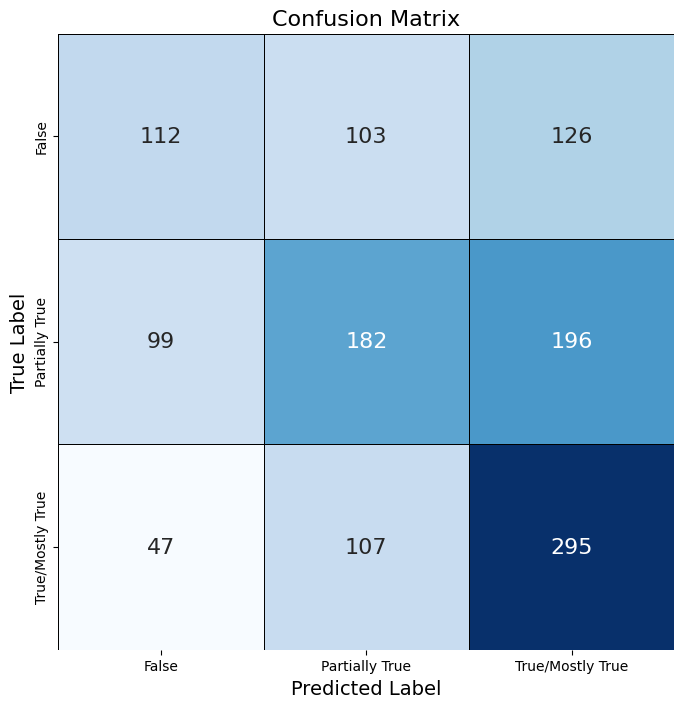

In [241]:
# make nice confusion matrix
# CHATGPT assisted with the code to obtain this formatted matrix

cm = confusion_matrix(y_true, predicted_labels)

cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            linewidths=0.5, linecolor='black', annot_kws={"size": 16})

plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

plt.show()

In [5]:
# read in for plots
# saved from the fine-tuned BERT

predictions = pd.read_csv('predictions.csv')

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


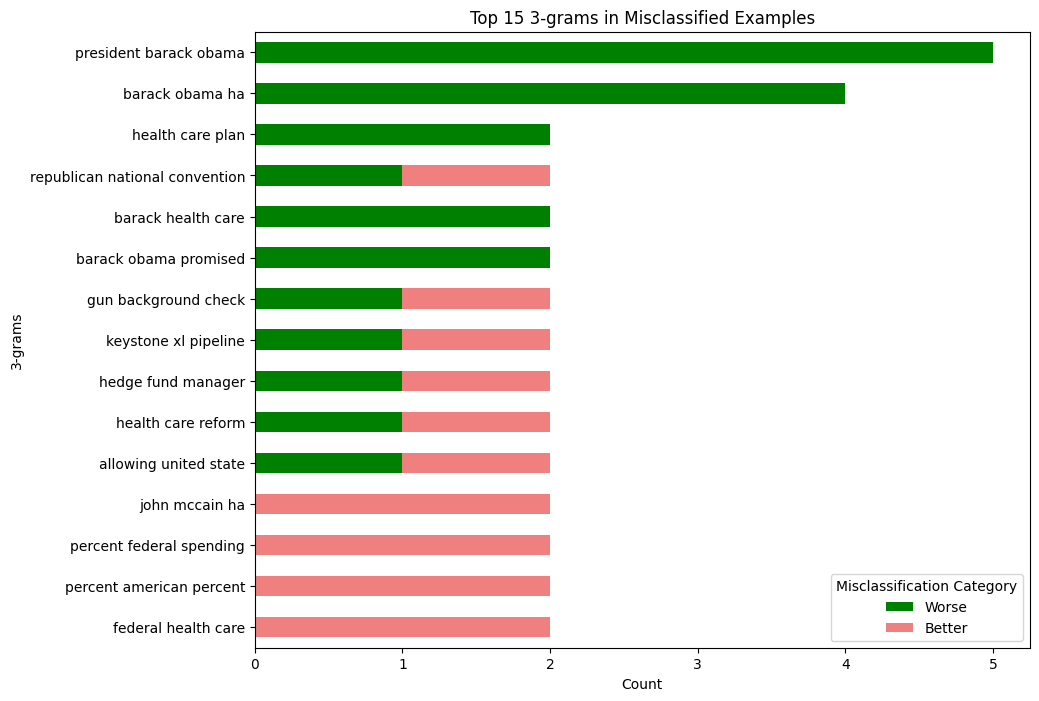

In [55]:
# CHATGPT Assisted with plotting functions

# lemmatizer for n-grams so that we can get rid of plurals
lemmatizer = WordNetLemmatizer()
def tokenize_and_lemma(text):
    return [lemmatizer.lemmatize(word) for word in text.split() if word.isalpha()]

y_true = np.array(predictions['True_Label'])
y_pred = np.array(predictions['Predicted_Label'])


# index misclassified examples
misclassified_idx = np.where(y_true != y_pred)[0]
misclassified_texts = X_test[misclassified_idx]
y_true_misclassified = y_true[misclassified_idx]
y_pred_misclassified = y_pred[misclassified_idx]


# define misclassifications as either "better" (more favorable prediction) or "worse" (less favorable)
def categorize_misclassification(true, pred):
    if true != pred:
        if true == 'False' and pred in ['Partially True', 'True/Mostly True']:
            return 'Better'
        elif true == 'Partially True' and pred == 'False':
            return 'Worse'
        elif true == 'Partially True' and pred == 'True/Mostly True':
            return 'Better'
        elif true == 'True/Mostly True' and pred == 'False':
            return 'Worse'
        elif true == 'True/Mostly True' and pred == 'Partially True':
            return 'Worse'
    return None
categories = [categorize_misclassification(true, pred) for true, pred in zip(y_true_misclassified, y_pred_misclassified)]
category_ngram_counts = {'Worse': {}, 'Better': {}}

# get rid of "say" and "obamas" as they are causing far too similar trigrams
custom_stop_words = list(set(ENGLISH_STOP_WORDS).union({'say', 'obamas'}))
# add custom stop words to count vectorizer
vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words=custom_stop_words, tokenizer=tokenize_and_lemma)

for text, category in zip(misclassified_texts, categories):
    if category:
        try:

            # tokenize
            ngrams = vectorizer.fit_transform([text])
            if not vectorizer.vocabulary_:
                continue

            ngram_names = vectorizer.get_feature_names_out()
            ngram_freqs = np.asarray(ngrams.sum(axis=0)).flatten()
            for ngram, count in zip(ngram_names, ngram_freqs):
                if ngram in category_ngram_counts[category]:
                    category_ngram_counts[category][ngram] += count
                else:
                    category_ngram_counts[category][ngram] = count
        except ValueError:
            continue

ngram_df = pd.DataFrame(category_ngram_counts).fillna(0)

# green for "better", "red" for "worse"
color_scheme = ['green', 'lightcoral']

# get top 15 ngrams
ngram_df['total'] = ngram_df.sum(axis=1)
top_15_ngrams = ngram_df.nlargest(15, 'total').drop(columns='total')

# breakdown by category
top_15_ngrams.plot(kind='barh', stacked=True, figsize=(10, 8), color=color_scheme)
plt.xlabel('Count')
plt.ylabel('3-grams')
plt.title('Top 15 3-grams in Misclassified Examples')
plt.gca().invert_yaxis()
plt.legend(title='Misclassification Category')
plt.show()


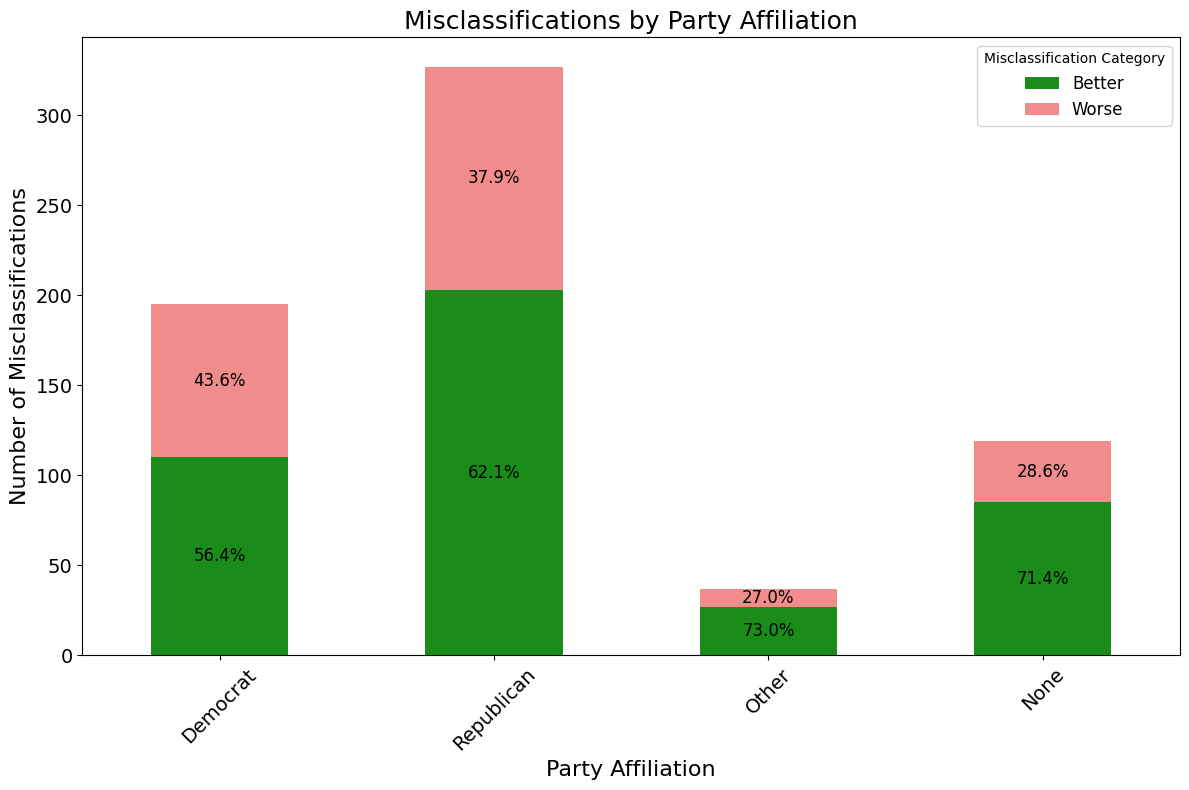

In [56]:
# CHATGPT assisted in the creation of this plot


# map party affiliation to smaller set of categories
def categorize_party(party):
    if party.lower() == 'democrat':
        return 'Democrat'
    elif party.lower() == 'republican':
        return 'Republican'
    elif party.lower() == 'none':
        return 'None'
    else:
        return 'Other'
predictions['party_affiliation'] = test_df['party affiliation'].apply(categorize_party)

# apply misclassifcations function from above
predictions['misclassification_category'] = [
    categorize_misclassification(true, pred)
    for true, pred in zip(predictions['True_Label'], predictions['Predicted_Label'])
]
misclassified = predictions[predictions['misclassification_category'].notnull()]

# group by party and misclassification
misclassification_counts = (
    misclassified.groupby(['party_affiliation', 'misclassification_category'])
    .size()
    .unstack(fill_value=0)
)

# order for plot
party_order = ['Democrat', 'Republican', 'Other', 'None']

misclassification_counts = misclassification_counts.reindex(party_order)
misclassification_percents = misclassification_counts.div(misclassification_counts.sum(axis=1), axis=0) * 100

# color scheme as before
color_scheme = ['green', 'lightcoral']

ax = misclassification_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=color_scheme,
    alpha=0.9
)


# add percentages to the plot
for i, party in enumerate(misclassification_counts.index):
    for j, category in enumerate(misclassification_counts.columns):
        value = misclassification_counts.loc[party, category]
        if value > 0:  # Only add text if there is a value
            percent = misclassification_percents.loc[party, category]
            ax.text(i, misclassification_counts.iloc[i, :j+1].sum() - (value / 2),
                    f'{percent:.1f}%', ha='center', va='center', fontsize=12, color='black')

plt.title('Misclassifications by Party Affiliation', fontsize=18)
plt.xlabel('Party Affiliation', fontsize=16)
plt.ylabel('Number of Misclassifications', fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Misclassification Category', fontsize=12)
plt.tight_layout()
plt.show()
